In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix, accuracy_score
from functools import reduce
from tqdm import tqdm

### 1. Import Data

In [3]:
hmda21_df = pd.read_csv('C:\Temp\hmda21_categorized.csv', dtype = str)

hmda21_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329539 entries, 0 to 5329538
Columns: 117 entries, activity_year to lmi_def
dtypes: object(117)
memory usage: 4.6+ GB


### 2. Filter for Conventional Originations and Denials and where income is above 0

In [4]:
hmda21_df['income'] = pd.to_numeric(hmda21_df['income'])

hmda21_df2 = hmda21_df[(hmda21_df['loan_type'] == '1') & (hmda21_df['income'] > 0) &\
                       ((hmda21_df['loan_outcome'] == '1') | (hmda21_df['loan_outcome'] == '3'))].copy()

print(len(hmda21_df2))

3287909


### 3. Create Dummy Variables for Regression

#### Select columns for dummy variables

In [5]:
regression_cols = [{'loan_outcome': {'denied': ['3']}},
                   
                   ### Reference: White
                   {'app_race_ethnicity': {'black': ['3'], 'latino': ['6'], 'asian': ['2'], 'native': ['1'],
                                           'pac_islander': ['4'], 'race_na': ['7'], 'asian_cb': ['2', '4']}},
                   
                   ### Reference: Coapplicant
                   {'co_applicant': {'no_coapplicant': ['2'], 'na_coapplicant': ['3']}},
                   
                   ### Reference: Male
                   {'applicant_sex_cat': {'female': ['2'], 'sex_na': ['3', '6']}},
                   
                   ### Reference: Between 34-44 or Between 34-54
                   {'applicant_age_cat': {'less_than25': ['1'], 'between25_34': ['2'], 
                                          'between45_54': ['4'], 'between55_64': ['5'], 'between65_74': ['6'],
                                          'greater74': ['7'], 'age_na': ['8'],
                                          'younger_than_34': ['1', '2'], 'older_than_55': ['5', '6', '7'],
                                          'older_than65': ['6', '7']}},
                   
                   ### Reference: Bucket 2 & 3
                   {'prop_value_cat': {'pvr_bucket1': ['1'], 'pvr_bucket4': ['4'], 'pvr_bucket5': ['5'], 
                                        'pvr_bucket6': ['6'], 'pvr_bucket_none': ['7']}},
                   
                   
                   ### Reference: 30yr Mortgage
                   {'mortgage_term': {'less30yrs_mortgage': ['2'], 'more30yrs_mortgage': ['3'], 
                                      'mortgage_term_na': ['4'], 'not30yr_mortgage': ['2', '3']}},
                   
                   ### Reference: TransUnion
                   {'app_credit_model': {'equifax': ['1'], 'experian': ['2'], 'other_model': ['4', '6'], 
                                         'more_than_one': ['5'], 'model_na': ['7']}},
                   
                   {'dti_cat': {'dti_manageable': ['2'], 'dti_unmanageable': ['3'], 
                                'dti_struggling': ['4'], 'dti_na': ['5', '6']}},
                   
                   ### Reference: 20 pct downpayment
                   {'downpayment_flag': {'less20pct_downpayment': ['2'],'downpayment_na': ['3', '5']}},
                   
                   ### Reference: Upper LMI
                   {'lmi_def': {'low_lmi': ['1'], 'moderate_lmi': ['2'], 'middle_lmi': ['3'], 'na_lmi': ['5']}},
                   
                   ### Reference: White Cat 1
                   {'diverse_def': {'white_cat2': ['2'], 'white_cat3': ['3'], 'white_cat4': ['4'], 
                                      'white_cat_na': ['0', '5']}},
                   
                   ### Reference: Banks
                   {'lender_def': {'credit_union': ['2'], 'independent': ['3'],  'lender_na': ['4', '6']}},

                   ### Reference: 99th Percentile
                   {'metro_percentile': {'metro_90th': ['9'], 'metro_80th': ['8'],
                                         'metro_70th': ['7'], 'metro_60th': ['6'], 'metro_50th': ['5'],
                                         'metro_40th': ['4'], 'metro_30th': ['3'], 'metro_20th': ['2'],
                                         'metro_10th': ['1'], 'metro_less10th': ['0'], 'micro_area': ['111'],
                                         'metro_none': ['000']}}]

In [6]:
continous_vars = ['income_log', 'loan_log', 'lar_count', 'property_value_ratio', 'prop_zscore']

for continuous_var in continous_vars:
    hmda21_df2[continuous_var] = pd.to_numeric(hmda21_df2[continuous_var])

In [7]:
def create_dummy_vars(df, columns):
    '''
    Create dummy variables based on values being isolated in the list of dict being passed
    '''
    
    
    for column in columns:
        dummy_vars = columns[column]
        
        for dummy_var in dummy_vars:
            
            var_value = dummy_vars[dummy_var]

            df.loc[(df[column].isin(var_value)), dummy_var] = 0
            df.loc[~(df[column].isin(var_value)), dummy_var] = 1
    
    return df

In [8]:
for columns in regression_cols:
    ### Function to create dummy variables
    hmda21_df2 = create_dummy_vars(hmda21_df2, columns)

#### Independent Variables

In [9]:
variables = ['black', 'latino', 'asian_cb', 'native', 'race_na',
             'no_coapplicant', 'na_coapplicant',
             'female', 'sex_na',
             'less_than25', 'between25_34', 'between45_54', 'between55_64', 'older_than65', 'age_na',
             'income_log', 'loan_log',
             'pvr_bucket1', 'pvr_bucket4', 'pvr_bucket5', 'pvr_bucket6', 'pvr_bucket_none',
             'less30yrs_mortgage', 'more30yrs_mortgage', 'mortgage_term_na',
             'equifax', 'experian', 'other_model', 'more_than_one', 'model_na',
             'dti_manageable', 'dti_unmanageable', 'dti_struggling', 'dti_na',
             'less20pct_downpayment','downpayment_na',
             'moderate_lmi', 'middle_lmi', 'low_lmi', 'na_lmi',
             'credit_union', 'independent',  'lender_na',
             'lar_count',             
             'white_cat2', 'white_cat3', 'white_cat4', 'white_cat_na',
             'metro_90th', 'metro_80th', 'metro_70th', 'metro_60th', 'metro_50th', 'metro_40th', 
             'metro_30th', 'metro_20th', 'metro_10th', 'metro_less10th', 'micro_area', 'metro_none']

print(len(variables))

60


### 2. Run Collinearity Test

In [10]:
def calculate_vif(independet_df):
    '''
    Calculate VIF
    '''
    
    vif_list = []
    
    x_cols = independet_df.columns
    
    for x_col in tqdm(x_cols):
        
        x = independet_df[[x_col]]
        y = independet_df.drop(columns = x_col)
        
        rsq = smf.ols(formula = 'x~y', data = independet_df).fit().rsquared
        vif = round(1/(1-rsq), 2)
        
        if vif > 2.5:
            ### 1 for concern
            threshold_flag = '1'
            
        elif vif <= 2.5:
            ### 0 for no concern
            threshold_flag = '0'
        
        
        var_dict = {'independent_var': x_col, 'vif': vif, 'threshold': threshold_flag}
        vif_list.append(var_dict)
        
    vif_df = pd.DataFrame(vif_list)
    return vif_df

In [11]:
hmda_independent_vars = hmda21_df2[variables]

vif_df = calculate_vif(hmda_independent_vars)

100%|██████████| 60/60 [18:10<00:00, 18.17s/it]


#### Varibales that are above the 2.5 threshold

In [12]:
vif_df[(vif_df['threshold'] == '1')].sort_values(by = ['vif'], ascending = False)

,independent_var,vif,threshold
21,pvr_bucket_none,7.40,1
33,dti_na,6.58,1
47,white_cat_na,6.38,1
39,na_lmi,5.31,1
35,downpayment_na,4.96,1
24,mortgage_term_na,3.80,1
16,loan_log,3.06,1
15,income_log,2.93,1
48,metro_90th,2.80,1


#### Remove variables with high VIFs
- Keeping income, loan and metro_90th

In [13]:
to_keep = ['income_log', 'loan_log', 'metro_90th']

highvif_vars = vif_df[(vif_df['threshold'] == '1') & ~(vif_df['independent_var'].isin(to_keep))]\
              ['independent_var'].unique().tolist()

variables2 = [var for var in variables if var not in highvif_vars]

### 3. Filter Out High Vif Variables
- Property Value Ratios NA
- Mortgage Term NA
- DTI NA
- Downpayment NA
- NA Lmi
- White Cat NA

In [14]:
hmda21_df3 = hmda21_df2[(hmda21_df2['prop_value_cat'] != '7') & (hmda21_df2['mortgage_term'] != '4') &\
                        (hmda21_df2['dti_cat'] != '5') & (hmda21_df2['dti_cat'] != '6') &\
                        (hmda21_df2['downpayment_flag'] != '3') & (hmda21_df2['lmi_def'] != '5') &\
                        (hmda21_df2['diverse_def'] != '0') & (hmda21_df2['diverse_def'] != '5')].copy()

print(len(hmda21_df3))

3163085


#### Also filtering out CLTV above 100

In [15]:
hmda21_df3['combined_loan_to_value_ratio'] = pd.to_numeric(hmda21_df3['combined_loan_to_value_ratio'])

hmda21_df4 = hmda21_df3[(hmda21_df3['combined_loan_to_value_ratio'] <= 100)]

print(len(hmda21_df4))

3112469


#### Replace variables

In [16]:
# high_vif_vars = ['pvr_bucket_none', 'mortgage_term_na', 'dti_na', 'downpayment_na', 'na_lmi', 'white_cat_na']

vars_to_removes = ['pvr_bucket1', 'pvr_bucket4', 'pvr_bucket5', 'pvr_bucket6', 'less20pct_downpayment']

variables3 = [var for var in variables2 if var not in vars_to_removes]
variables3.insert(17, 'property_value_ratio')
variables3.insert(28, 'combined_loan_to_value_ratio')

#### Variables to use

In [17]:
pd.Series(variables3)

0                            black
1                           latino
2                         asian_cb
3                           native
4                          race_na
5                   no_coapplicant
6                   na_coapplicant
7                           female
8                           sex_na
9                      less_than25
10                    between25_34
11                    between45_54
12                    between55_64
13                    older_than65
14                          age_na
15                      income_log
16                        loan_log
17            property_value_ratio
18              less30yrs_mortgage
19              more30yrs_mortgage
20                         equifax
21                        experian
22                     other_model
23                   more_than_one
24                        model_na
25                  dti_manageable
26                dti_unmanageable
27                  dti_struggling
28    combined_loan_

### 4. Run Regression
#### Regression Formula

In [18]:
    
def create_formula(independent_vars):
    '''
    Create formula from a list of variables
    '''
    
    
    dummy_vars = str(str(independent_vars)[2:-2].replace('\', \'', ' + '))
    regression_formula = ("denied ~ " + dummy_vars)
    
    return regression_formula
    

In [19]:
regression_formula = create_formula(variables3)
regression_formula

'denied ~ black + latino + asian_cb + native + race_na + no_coapplicant + na_coapplicant + female + sex_na + less_than25 + between25_34 + between45_54 + between55_64 + older_than65 + age_na + income_log + loan_log + property_value_ratio + less30yrs_mortgage + more30yrs_mortgage + equifax + experian + other_model + more_than_one + model_na + dti_manageable + dti_unmanageable + dti_struggling + combined_loan_to_value_ratio + moderate_lmi + middle_lmi + low_lmi + credit_union + independent + lender_na + lar_count + white_cat2 + white_cat3 + white_cat4 + metro_90th + metro_80th + metro_70th + metro_60th + metro_50th + metro_40th + metro_30th + metro_20th + metro_10th + metro_less10th + micro_area + metro_none'

In [20]:
print('Number of records: ' + str(len(hmda21_df4)))

Number of records: 3112469


In [21]:
def run_regression(data, formula):
    '''
    use statsmodel to run regression
    '''
    
    model = smf.logit(data = data, formula = formula)
    
    return model

In [22]:
model = run_regression(data = hmda21_df4, formula = regression_formula).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.180396
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 denied   No. Observations:              3112469
Model:                          Logit   Df Residuals:                  3112417
Method:                           MLE   Df Model:                           51
Date:                Sat, 27 Aug 2022   Pseudo R-squ.:                  0.2190
Time:                        21:19:36   Log-Likelihood:            -5.6148e+05
converged:                       True   LL-Null:                   -7.1894e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -10.1011      0.301    -33.523      0.000     -10.692      -9.511
black                            0.6718      0.011     63.527      0.000       0.651       0.693
latino                           0.4198      0.009     47.740      0.000       0.403       0.437
asian_cb                         0.4084      0.010     42.260      0.000       0.390       0.427
native                           0.5180      0.035     14.952      0.000       0.450       0.586
race_na                          0.4202      0.010     40.914      0.000       0.400       0.440
no_coapplicant                   0.2623      0.006     42.125      0.000       0.250       0.275
na_coapplicant                   0.3959      0.111      3.579      0.000       0.179       0.613
female                          -0.0792      0.006    -13.341      0.000      -0.091      -0.068
sex_na                           0.2028      0.013     15.414      0.000       0.177       0.229
less_than25                     -0.0287      0.013     -2.177      0.030      -0.055      -0.003
between25_34                    -0.2080      0.007    -28.310      0.000      -0.222      -0.194
between45_54                     0.1407      0.008     17.497      0.000       0.125       0.157
between55_64                     0.1076      0.009     11.551      0.000       0.089       0.126
older_than65                    -0.0756      0.012     -6.458      0.000      -0.099      -0.053
age_na                           1.6827      0.235      7.149      0.000       1.221       2.144
income_log                      -0.1237      0.006    -20.013      0.000      -0.136      -0.112
loan_log                         0.4680      0.007     69.655      0.000       0.455       0.481
property_value_ratio            -0.0620      0.002    -29.112      0.000      -0.066      -0.058
less30yrs_mortgage              -0.0170      0.011     -1.559      0.119      -0.038       0.004
more30yrs_mortgage               0.4595      0.023     20.272      0.000       0.415       0.504
equifax                         -0.0356      0.007     -5.161      0.000      -0.049      -0.022
experian                         0.0473      0.007      6.476      0.000       0.033       0.062
other_model                      0.8627      0.019     44.374      0.000       0.825       0.901
more_than_one                   -0.2460      0.018    -13.784      0.000      -0.281      -0.211
model_na                         0.2788      0.011     25.146      0.000       0.257       0.301
dti_manageable                   0.0115      0.007      1.588      0.112      -0.003       0.026
dti_unmanageable                 0.3002      0.008     39.945      0.000       0.286       0.315
dti_struggling                   4.3050      0.011    406.727      0.000       4.284       4.326
combined_loan_to_value_ratio    -0.0106      0.000    -50.200      0.000      -0.011      -0.010
moderate_lmi                     0.0803 

In [23]:
def convert_results_to_df(model):
    '''
    Convert the summary results from regression into dataframe
    '''
    
    coef_dict = {'results': dict(model.params), 'col_name': 'coefficient'}
    std_error_dict = {'results': dict(model.bse), 'col_name': 'standard_error'}
    tvalues_dict = {'results': dict(model.tvalues), 'col_name': 'z_value'}
    pvalues_dict = {'results': dict(model.pvalues), 'col_name': 'p_value'}
    oddsratio_dict = {'results': dict(np.exp(model.params)), 'col_name': 'odds_ratio'}
    
    results_dicts = [coef_dict, std_error_dict, tvalues_dict, pvalues_dict, oddsratio_dict]
    
    dfs = []    
    for results_dict in results_dicts:
        col_name = results_dict['col_name']
        df = pd.DataFrame.from_dict(results_dict['results'], orient = 'index').reset_index().rename(columns = {'index': 'variable_name', 0: col_name})
        dfs.append(df)

    
    results_df = reduce(lambda left, right: pd.merge(left, right, on = ['variable_name']), dfs)
    results_df.insert(1, 'pseudo_rsquared', model.prsquared)
    
    return results_df

In [24]:
national_findings_df = convert_results_to_df(model)

races = ['black', 'latino', 'native', 'asian_cb']
national_findings_df[(national_findings_df['variable_name'].isin(races))]

,variable_name,pseudo_rsquared,coefficient,standard_error,z_value,p_value,odds_ratio
1,black,0.219017,0.671828,0.010575,63.527119,0.000000e+00,1.957813
2,latino,0.219017,0.419847,0.008794,47.739928,0.000000e+00,1.521729
3,asian_cb,0.219017,0.408447,0.009665,42.260345,0.000000e+00,1.504479
4,native,0.219017,0.518002,0.034644,14.952358,1.503309e-50,1.678670


#### DTI Categories Findings

In [25]:
dti_vars = ['dti_manageable', 'dti_unmanageable', 'dti_struggling']

national_findings_df[(national_findings_df['variable_name'].isin(dti_vars))]

,variable_name,pseudo_rsquared,coefficient,standard_error,z_value,p_value,odds_ratio
26,dti_manageable,0.219017,0.011464,0.007218,1.588348,0.112208,1.011530
27,dti_unmanageable,0.219017,0.300234,0.007516,39.945139,0.000000,1.350175
28,dti_struggling,0.219017,4.304976,0.010584,406.727169,0.000000,74.067422


In [26]:
national_findings_df.to_csv('C:\Temp\overall_findings.csv',index = False)

<AxesSubplot:xlabel='variable_name'>

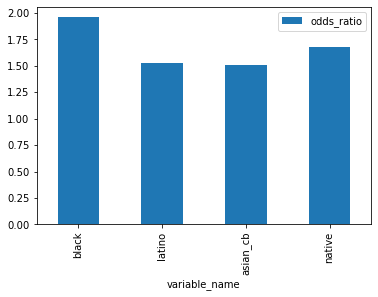

In [27]:
national_findings_df[(national_findings_df['variable_name'].isin(races))].plot(x="variable_name", y="odds_ratio", kind="bar")

### 5. Findings:
#### Racial and ethnic findings
- Black applicants are almost twice as likely to be denied 
- Latinx/Hispanic are almost 1.5 times
- Native Applicants are 1.7 times
- Asian/Pacific Isalnder are 1.5

### 6. Additional statistical tests
#### Check for collinearity again

In [28]:
cols = national_findings_df['variable_name'].unique().tolist()[1:]

hmda_independent_vars2 = hmda21_df4[cols]
vif_df2 = calculate_vif(hmda_independent_vars2)

100%|██████████| 51/51 [12:58<00:00, 15.26s/it]


No new additional varibales that are collinear

In [29]:
vif_df2[(vif_df2['threshold'] == '1')]

,independent_var,vif,threshold
15,income_log,2.92,1
16,loan_log,2.84,1
39,metro_90th,2.74,1


#### Calculate Confusion Matrix

In [30]:
def calcuate_confusion_matrix(df, model, indepndent_vars, dependent_vars):
    '''
    Calculate confusion matrix
    '''
    
    
    testX = df[indepndent_vars]
    testY = df[dependent_vars]
    
    
    yhat = model.predict(testX)
    prediction = list(map(round, yhat))
    
    cm = confusion_matrix(testY, prediction)  
    print ("Confusion Matrix : \n", cm)
    
    # accuracy score of the model 
    print('Overall accuracy: ', accuracy_score(testY, prediction) * 100)
    print('Denied accuracy: ', (cm[0, 0]/(cm[0, 0] + cm[0, 1])) * 100)
    print('Loan accuracy : ', (cm[1, 1]/(cm[1, 0] + cm[1, 1])) * 100)
    

In [31]:
calcuate_confusion_matrix(hmda21_df3, model, cols, ['denied'])

C:\Users\sumit.kamarajugadda\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Confusion Matrix : 
 [[  62929  142503]
 [  20717 2936936]]
Overall accuracy:  94.83984780680886
Denied accuracy:  30.632520736788816
Loan accuracy :  99.29954595755486


### 7. Export Findings and Data


In [32]:
cols_to_export = cols + ['denied', 'loan_outcome', 'younger_than_34', 'older_than_55', 'not30yr_mortgage', 
                         'metro_code', 'lei', 'app_race_ethnicity', 'app_credit_model', 'property_value_ratio']

In [35]:
hmda21_df5 = hmda21_df4[cols_to_export]
hmda21_df5.to_csv('c:/temp/hmda2021_regressiondata_1.csv', index = False)